In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
import pandas as pd

In [2]:
import os

In [3]:
import ast  # Safer than eval for converting strings to lis

In [4]:
import random
np.random.seed(1)
random.seed(1)

In [5]:
os.getcwd()

'C:\\Users\\DELL\\Research_projects\\Random_walk_prediction'

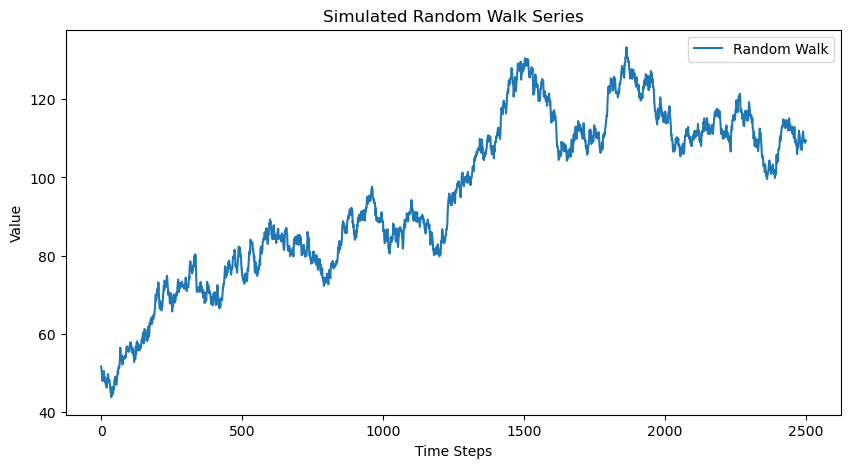

In [6]:
# Parameters
n_steps = 2500  # Number of steps in the random walk
initial_value = 50  # Initial positive value to ensure all steps remain positive
np.random.seed(1)  # Seed for reproducibility
train_size = 2300  # Size of the training set
# Simulate random walk data
steps = np.random.normal(0, 1, n_steps).cumsum()  # Generate normal steps
data = steps + initial_value  # Offset by the initial value to keep values positive

# Display the random walk series
plt.figure(figsize=(10, 5))
plt.plot(data, label='Random Walk')
plt.title('Simulated Random Walk Series')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.savefig("C:\\Users\\DELL\\Research_projects\\Random_walk_prediction\\figures\\Simulated_random_walk.png", dpi = 300)
plt.show()

In [7]:
# Split the data into train and test sets
train_data = data[:train_size]
test_data = data[train_size:]

# Generate naive forecast for the training set
naive_train = train_data[:-1]
y_train = train_data[1:]

# Calculate residuals in the training set
residuals_train = np.abs(y_train - naive_train)

# Calculate the mean of the residuals
mean_residual = np.mean(residuals_train)

# Generate naive forecast for the test set
naive_test = data[train_size-1:-1]
y_test = test_data

# Accuracy settings and trials
start_accuracy = 0.50
end_accuracy = 1.00
accuracy_step = 0.05
n_trials = 100
results = {}
# Calculate MSE and MAE for naive forecast
naive_mse = np.mean((y_test - naive_test)**2)
naive_mae = np.mean(np.abs(y_test - naive_test))


# Fusion with optimal weights

In [9]:
# Initialize an empty DataFrame outside the loop
results_df = pd.DataFrame()

for accuracy in np.arange(start_accuracy, end_accuracy + accuracy_step, accuracy_step):
    weight = 2 * accuracy - 1
    threshold_mse = (2 + weight) / 4
    improvement_mse = (4 * weight * accuracy - weight**2 - 2 * weight) * mean_residual**2
    
    for trial in range(n_trials):
        actual_movements_test = np.sign(np.diff(test_data, prepend=train_data[-1]))
        actual_movements_test = (actual_movements_test == 1).astype(int)
        predicted_movements = np.copy(actual_movements_test)
        mask = np.random.rand(len(test_data)) < accuracy
        incorrect_mask = ~mask
        predicted_movements[incorrect_mask] = 1 - predicted_movements[incorrect_mask]

        y_fusion = np.zeros_like(y_test)  # Assuming y_test is predefined
        for i in range(len(y_test)):
            y_fusion[i] = naive_test[i] + (weight * mean_residual if predicted_movements[i] == 1 else -weight * mean_residual)

        mse_fusion = np.mean((y_test - y_fusion)**2)
        mae_fusion = np.mean(np.abs(y_test - y_fusion))
        

        # Create a temporary DataFrame for this trial and append it
        trial_df = pd.DataFrame({
            'accuracy': [accuracy],
            'trial': [trial],
            'predicted_movements': [predicted_movements.tolist()],  # Convert array to list for storage
            'mse_fusion': [mse_fusion],
            'mae_fusion': [mae_fusion],
            'threshold_mse': [threshold_mse],
            'improvement_mse': [improvement_mse]
        })

        # Append trial_df to results_df
        results_df = pd.concat([results_df, trial_df], ignore_index=True)

In [10]:
# Specify the path and file name where you want to save the CSV
csv_file_path = 'C:\\Users\\DELL\\Research_projects\\Random_walk_prediction\\files\\simulation_results_acc_optimal.csv'
results_df.to_csv(csv_file_path, index=False)
print(f"Results saved to {csv_file_path}")

Results saved to C:\Users\DELL\Research_projects\Random_walk_prediction\files\simulation_results_acc_optimal.csv


In [11]:
# Assuming results_df is already defined and contains the necessary columns
# Group the results by accuracy and calculate required statistics
grouped = results_df.groupby('accuracy')
summary = grouped.agg({
    'mse_fusion': ['mean', 'std', 'min', 'max'],
    'mae_fusion': ['mean', 'std', 'min', 'max'],
    'improvement_mse': 'first', # Assuming these are constants per accuracy level
    'threshold_mse': 'first'
}).reset_index()

# Flatten the column names after aggregation
summary.columns = ['_'.join(col).strip() if col[1] else col[0] for col in summary.columns.values]

# Print statistical summaries
print("Statistical Summary of Fusion Forecast Performance:")
for index, row in summary.iterrows():
    accuracy = row['accuracy']

    mean_mse = row['mse_fusion_mean']
    std_mse = row['mse_fusion_std']
    mean_mae = row['mae_fusion_mean']
    std_mae = row['mae_fusion_std']
    expected_improvement_mse = row['improvement_mse_first']

    threshold_mse = row['threshold_mse_first']

    # Calculate actual improvements
    actual_improvement_mse = abs(naive_mse - mean_mse)
    actual_improvement_mae = abs(naive_mae - mean_mae)


    print(f"Accuracy: {accuracy:.2f}")
    print(f"  MSE: {mean_mse:.3f} ± {std_mse:.3f}, Threshold ACC: {threshold_mse:.3f}")
    print(f"  MAE: {mean_mae:.3f} ± {std_mae:.3f}")
    print(f"  Expected vs Actual Improvement MSE: {expected_improvement_mse:.3f} vs {actual_improvement_mse:.3f}")



Statistical Summary of Fusion Forecast Performance:
Accuracy: 0.50
  MSE: 1.044 ± 0.000, Threshold ACC: 0.500
  MAE: 0.821 ± 0.000
  Expected vs Actual Improvement MSE: 0.000 vs 0.000
Accuracy: 0.55
  MSE: 1.037 ± 0.011, Threshold ACC: 0.525
  MAE: 0.816 ± 0.005
  Expected vs Actual Improvement MSE: 0.006 vs 0.007
Accuracy: 0.60
  MSE: 1.017 ± 0.026, Threshold ACC: 0.550
  MAE: 0.802 ± 0.012
  Expected vs Actual Improvement MSE: 0.026 vs 0.028
Accuracy: 0.65
  MSE: 0.982 ± 0.039, Threshold ACC: 0.575
  MAE: 0.775 ± 0.018
  Expected vs Actual Improvement MSE: 0.058 vs 0.063
Accuracy: 0.70
  MSE: 0.939 ± 0.044, Threshold ACC: 0.600
  MAE: 0.745 ± 0.019
  Expected vs Actual Improvement MSE: 0.102 vs 0.106
Accuracy: 0.75
  MSE: 0.885 ± 0.052, Threshold ACC: 0.625
  MAE: 0.712 ± 0.022
  Expected vs Actual Improvement MSE: 0.160 vs 0.160
Accuracy: 0.80
  MSE: 0.794 ± 0.051, Threshold ACC: 0.650
  MAE: 0.664 ± 0.022
  Expected vs Actual Improvement MSE: 0.230 vs 0.251
Accuracy: 0.85
  MSE: 0.

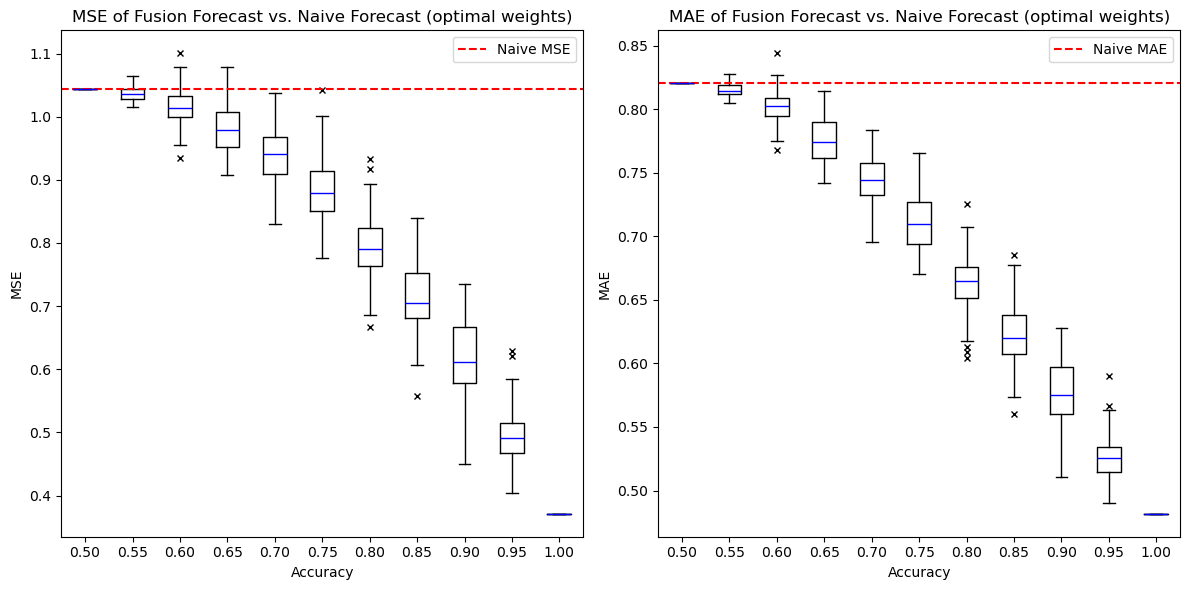

In [12]:
# Prepare data for boxplots
accuracies = sorted(results_df['accuracy'].unique())
all_mae = [results_df[results_df['accuracy'] == acc]['mae_fusion'].values for acc in accuracies]
all_mse = [results_df[results_df['accuracy'] == acc]['mse_fusion'].values for acc in accuracies]

flierprops = dict(marker = 'x', markersize = 4)
medianprops = dict(color = 'blue')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# MSE boxplot
ax1.boxplot(all_mse, labels=[f"{acc:.2f}" for acc in accuracies], flierprops = flierprops, medianprops = medianprops )
ax1.axhline(y=naive_mse, color='r', linestyle='--', label='Naive MSE')
ax1.set_title('MSE of Fusion Forecast vs. Naive Forecast (optimal weights)')
ax1.set_xlabel('Accuracy')
ax1.set_ylabel('MSE')
ax1.legend()

# MAE boxplot
ax2.boxplot(all_mae, labels=[f"{acc:.2f}" for acc in accuracies], flierprops = flierprops, medianprops = medianprops)
ax2.axhline(y=naive_mae, color='r', linestyle='--', label='Naive MAE')
ax2.set_title('MAE of Fusion Forecast vs. Naive Forecast (optimal weights)')
ax2.set_xlabel('Accuracy')
ax2.set_ylabel('MAE')
ax2.legend()

plt.tight_layout()
plt.savefig("C:\\Users\\DELL\\Research_projects\\Random_walk_prediction\\figures\\Simulated_random_walk_MAE_MSE_Comparison_optimal.png", dpi=300)
plt.show()

In [13]:
# Group by accuracy to handle calculations for each group separately
grouped_results = results_df.groupby('accuracy')

for accuracy, group in grouped_results:
    if accuracy == 0.5:
        continue
    
    # Extract MAE and MSE values
    mse_fusion = group['mse_fusion'].values
    mae_fusion = group['mae_fusion'].values
    
    # Calculate differences from the naive forecasts
    differences_mse = mse_fusion - naive_mse
    differences_mae = mae_fusion - naive_mae
 
    # Perform one-sample Wilcoxon signed-rank test
    stat_mse, p_value_mse = wilcoxon(differences_mse, alternative='two-sided')
    stat_mae, p_value_mae = wilcoxon(differences_mae, alternative='two-sided')
   
    print(f"Accuracy {accuracy:.2f}:")
    print(f"  MSE - Test Statistic: {stat_mse}, P-value: {p_value_mse:.4f}")
    print(f"  MAE - Test Statistic: {stat_mae}, P-value: {p_value_mae:.4f}")
    

Accuracy 0.55:
  MSE - Test Statistic: 876.0, P-value: 0.0000
  MAE - Test Statistic: 427.0, P-value: 0.0000
Accuracy 0.60:
  MSE - Test Statistic: 343.0, P-value: 0.0000
  MAE - Test Statistic: 80.0, P-value: 0.0000
Accuracy 0.65:
  MSE - Test Statistic: 82.0, P-value: 0.0000
  MAE - Test Statistic: 0.0, P-value: 0.0000
Accuracy 0.70:
  MSE - Test Statistic: 0.0, P-value: 0.0000
  MAE - Test Statistic: 0.0, P-value: 0.0000
Accuracy 0.75:
  MSE - Test Statistic: 0.0, P-value: 0.0000
  MAE - Test Statistic: 0.0, P-value: 0.0000
Accuracy 0.80:
  MSE - Test Statistic: 0.0, P-value: 0.0000
  MAE - Test Statistic: 0.0, P-value: 0.0000
Accuracy 0.85:
  MSE - Test Statistic: 0.0, P-value: 0.0000
  MAE - Test Statistic: 0.0, P-value: 0.0000
Accuracy 0.90:
  MSE - Test Statistic: 0.0, P-value: 0.0000
  MAE - Test Statistic: 0.0, P-value: 0.0000
Accuracy 0.95:
  MSE - Test Statistic: 0.0, P-value: 0.0000
  MAE - Test Statistic: 0.0, P-value: 0.0000
Accuracy 1.00:
  MSE - Test Statistic: 0.0, P-v

Unique accuracies in the dataset: [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
Filtered accuracies: [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
Processing accuracy: 0.50
Processing accuracy: 0.55
Processing accuracy: 0.60
Processing accuracy: 0.65
Processing accuracy: 0.70
Processing accuracy: 0.75
Processing accuracy: 0.80
Processing accuracy: 0.85
Processing accuracy: 0.90
Processing accuracy: 0.95
Processing accuracy: 1.00


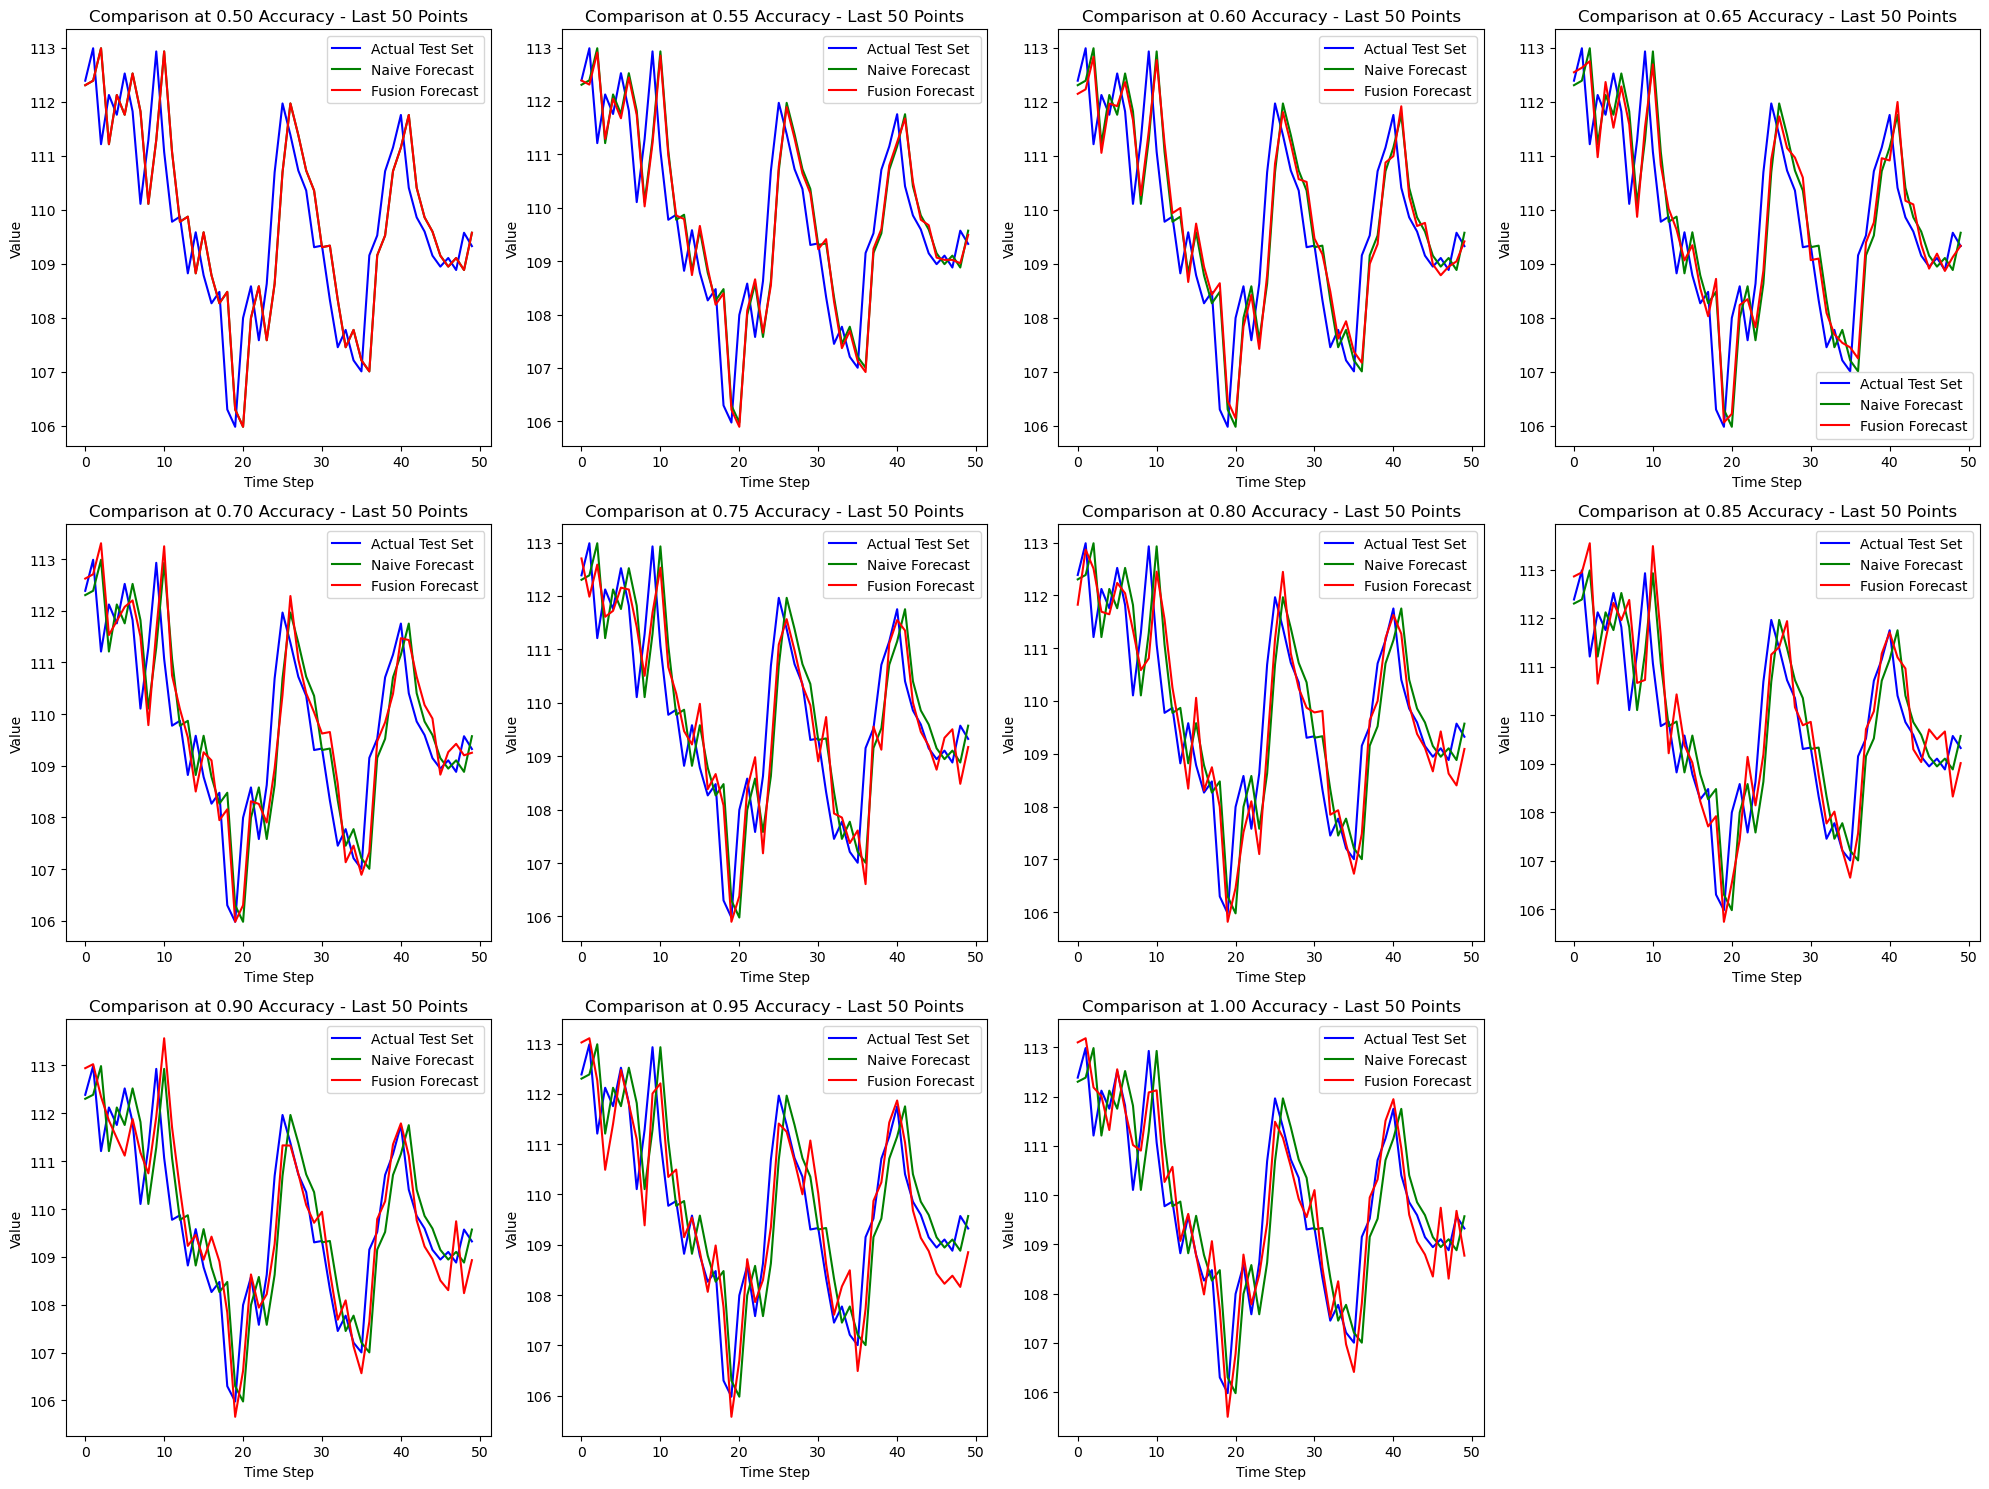

All processing complete


In [14]:
# Ensure the results_df, naive_test, mean_residual, and y_test are defined in your environment

# Create a figure and a set of subplots
fig, axes = plt.subplots(3, 4, figsize=(20, 15))  # 3 rows and 4 columns of subplots
points_to_display = 50
# Initialize a counter for subplot indexing
i = 0
results_df['accuracy'] = results_df['accuracy'].round(2)
# Get unique accuracies
unique_accuracies = sorted(results_df['accuracy'].unique())
print("Unique accuracies in the dataset:", unique_accuracies)  # Debug statement

# Filter accuracies that are multiples of 0.05
filtered_accuracies = [acc for acc in unique_accuracies if round(acc * 100) % 5 == 0]
print("Filtered accuracies:", filtered_accuracies)  # Debug statement

# Loop through filtered accuracies and plot
for accuracy in filtered_accuracies:
    print(f"Processing accuracy: {accuracy:.2f}")  # Debug statement

    # Calculate the position of the subplot
    row = i // 4
    col = i % 4
    ax = axes[row, col]

    # Extract the subset of the DataFrame for the current accuracy
    accuracy_df = results_df[results_df['accuracy'] == accuracy]
    average_mse = np.mean(accuracy_df['mse_fusion'])
    closest_trial = accuracy_df.iloc[(accuracy_df['mse_fusion'] - average_mse).abs().argmin()]

    # Check and convert predicted_movements
    predicted_movements_data = closest_trial['predicted_movements']
    if isinstance(predicted_movements_data, str):
        predicted_movements = np.array(ast.literal_eval(predicted_movements_data))
    else:
        predicted_movements = np.array(predicted_movements_data)

    # Calculate the fusion forecast
    weight = 2 * accuracy - 1  # Calculate weight based on accuracy
    fusion_forecast = naive_test[-points_to_display:] + weight * mean_residual * (2 * predicted_movements[-points_to_display:] - 1)

    # Select the last 50 points for plotting
    actual_last = y_test[-points_to_display:]
    naive_last = naive_test[-points_to_display:]
    fusion_last = fusion_forecast

    # Plotting
    ax.plot(actual_last, label='Actual Test Set', color='blue')
    ax.plot(naive_last, label='Naive Forecast', color='green')
    ax.plot(fusion_last, label='Fusion Forecast', color='red')
    ax.set_title(f'Comparison at {accuracy:.2f} Accuracy - Last 50 Points')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Value')
    ax.legend()

    # Increment the subplot index
    i += 1

# Adjust unused subplots
for index in range(i, 12):
    fig.delaxes(axes.flatten()[index])

plt.tight_layout()
plt.savefig("C:\\Users\\DELL\\Research_projects\\Random_walk_prediction\\figures\\Simulated_random_walk_visual_Comparison.png", dpi=300)
plt.show()

print("All processing complete")  # Debug statement

# Fusion with fixed weights

## Weight = 0.01

In [17]:
# Initialize an empty DataFrame outside the loop
results_df = pd.DataFrame()

for accuracy in np.arange(start_accuracy, end_accuracy + accuracy_step, accuracy_step):
    weight = 0.01
    threshold_mse = (2 + weight) / 4
    improvement_mse = (4 * weight * accuracy - weight**2 - 2 * weight) * mean_residual**2
    
    for trial in range(n_trials):
        actual_movements_test = np.sign(np.diff(test_data, prepend=train_data[-1]))
        actual_movements_test = (actual_movements_test == 1).astype(int)
        predicted_movements = np.copy(actual_movements_test)
        mask = np.random.rand(len(test_data)) < accuracy
        incorrect_mask = ~mask
        predicted_movements[incorrect_mask] = 1 - predicted_movements[incorrect_mask]

        y_fusion = np.zeros_like(y_test)  # Assuming y_test is predefined
        for i in range(len(y_test)):
            y_fusion[i] = naive_test[i] + (weight * mean_residual if predicted_movements[i] == 1 else -weight * mean_residual)

        mse_fusion = np.mean((y_test - y_fusion)**2)
        mae_fusion = np.mean(np.abs(y_test - y_fusion))
        

        # Create a temporary DataFrame for this trial and append it
        trial_df = pd.DataFrame({
            'accuracy': [accuracy],
            'trial': [trial],
            'predicted_movements': [predicted_movements.tolist()],  # Convert array to list for storage
            'mse_fusion': [mse_fusion],
            'mae_fusion': [mae_fusion],
            'threshold_mse': [threshold_mse],
            'improvement_mse': [improvement_mse]
        })

        # Append trial_df to results_df
        results_df = pd.concat([results_df, trial_df], ignore_index=True)

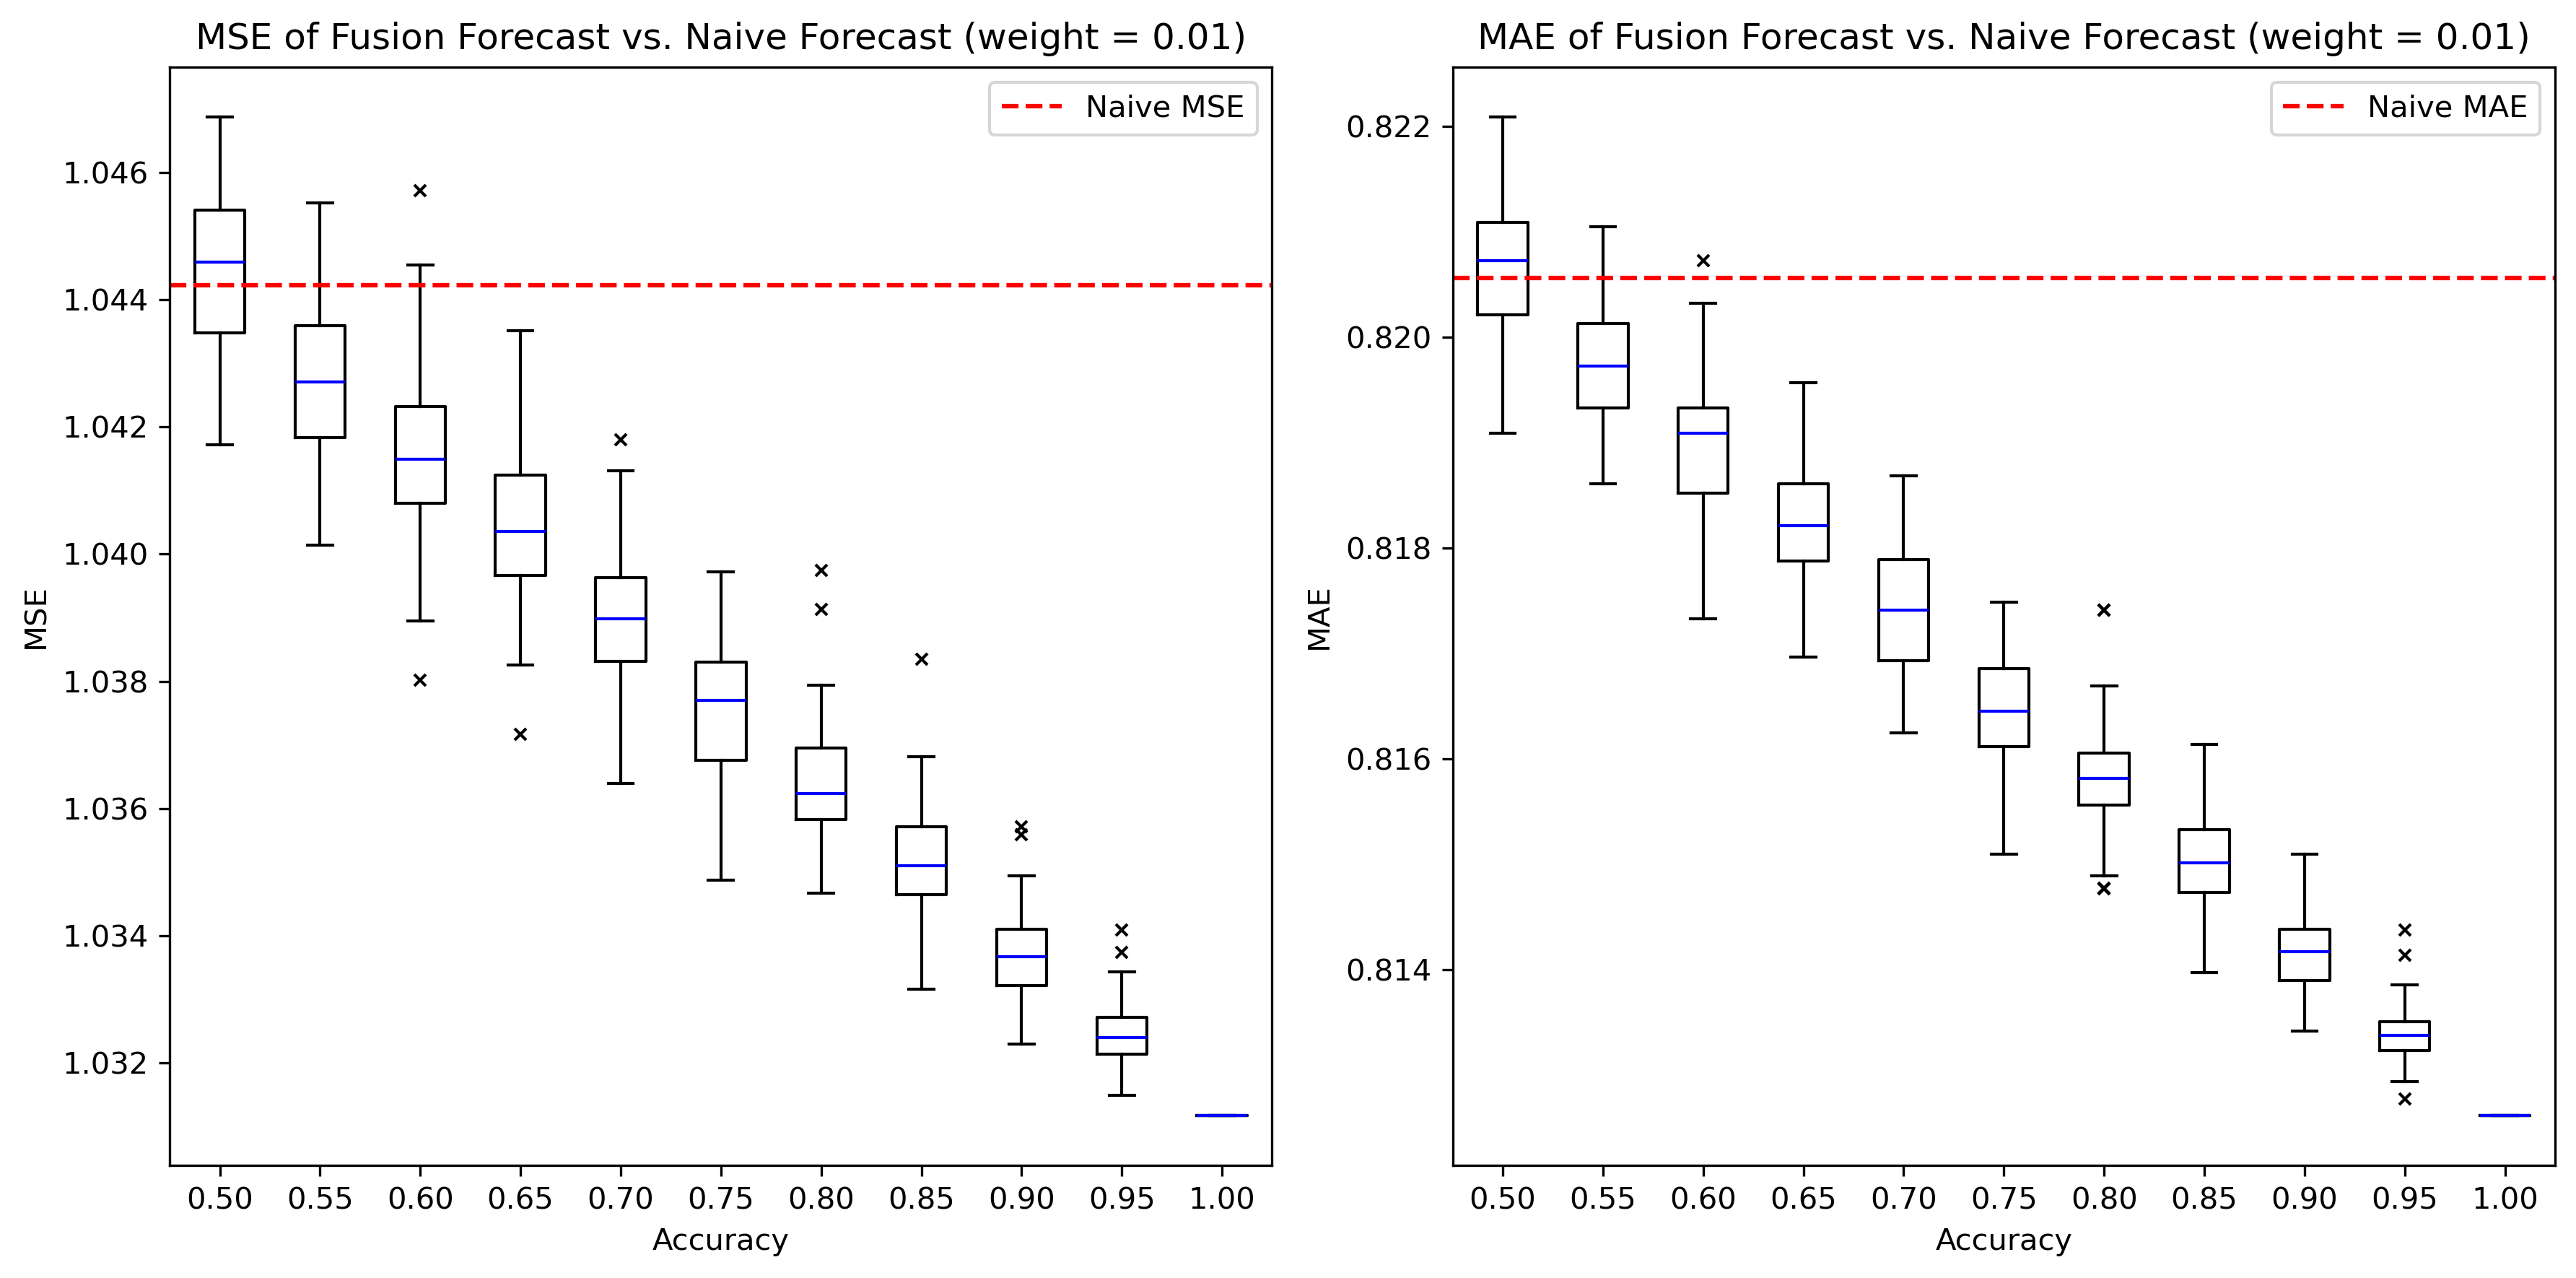

In [18]:
# Prepare data for boxplots
accuracies = sorted(results_df['accuracy'].unique())
all_mae = [results_df[results_df['accuracy'] == acc]['mae_fusion'].values for acc in accuracies]
all_mse = [results_df[results_df['accuracy'] == acc]['mse_fusion'].values for acc in accuracies]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

# MSE boxplot
ax1.boxplot(all_mse, labels=[f"{acc:.2f}" for acc in accuracies], flierprops = flierprops, medianprops = medianprops)
ax1.axhline(y=naive_mse, color='r', linestyle='--', label='Naive MSE')
ax1.set_title('MSE of Fusion Forecast vs. Naive Forecast (weight = 0.01)')
ax1.set_xlabel('Accuracy')
ax1.set_ylabel('MSE')
ax1.legend()

# MAE boxplot
ax2.boxplot(all_mae, labels=[f"{acc:.2f}" for acc in accuracies], flierprops = flierprops, medianprops = medianprops)
ax2.axhline(y=naive_mae, color='r', linestyle='--', label='Naive MAE')
ax2.set_title('MAE of Fusion Forecast vs. Naive Forecast (weight = 0.01)')
ax2.set_xlabel('Accuracy')
ax2.set_ylabel('MAE')
ax2.legend()

plt.tight_layout()
plt.savefig("C:\\Users\\DELL\\Research_projects\\Random_walk_prediction\\figures\\Simulated_random_walk_MAE_MSE_Comparison_0.01.png", dpi=300)
plt.show()

## Weight = 0.1

In [20]:
# Initialize an empty DataFrame outside the loop
results_df = pd.DataFrame()

for accuracy in np.arange(start_accuracy, end_accuracy + accuracy_step, accuracy_step):
    weight = 0.1
    threshold_mse = (2 + weight) / 4
    improvement_mse = (4 * weight * accuracy - weight**2 - 2 * weight) * mean_residual**2
    
    for trial in range(n_trials):
        actual_movements_test = np.sign(np.diff(test_data, prepend=train_data[-1]))
        actual_movements_test = (actual_movements_test == 1).astype(int)
        predicted_movements = np.copy(actual_movements_test)
        mask = np.random.rand(len(test_data)) < accuracy
        incorrect_mask = ~mask
        predicted_movements[incorrect_mask] = 1 - predicted_movements[incorrect_mask]

        y_fusion = np.zeros_like(y_test)  # Assuming y_test is predefined
        for i in range(len(y_test)):
            y_fusion[i] = naive_test[i] + (weight * mean_residual if predicted_movements[i] == 1 else -weight * mean_residual)

        mse_fusion = np.mean((y_test - y_fusion)**2)
        mae_fusion = np.mean(np.abs(y_test - y_fusion))
        

        # Create a temporary DataFrame for this trial and append it
        trial_df = pd.DataFrame({
            'accuracy': [accuracy],
            'trial': [trial],
            'predicted_movements': [predicted_movements.tolist()],  # Convert array to list for storage
            'mse_fusion': [mse_fusion],
            'mae_fusion': [mae_fusion],
            'threshold_mse': [threshold_mse],
            'improvement_mse': [improvement_mse]
        })

        # Append trial_df to results_df
        results_df = pd.concat([results_df, trial_df], ignore_index=True)

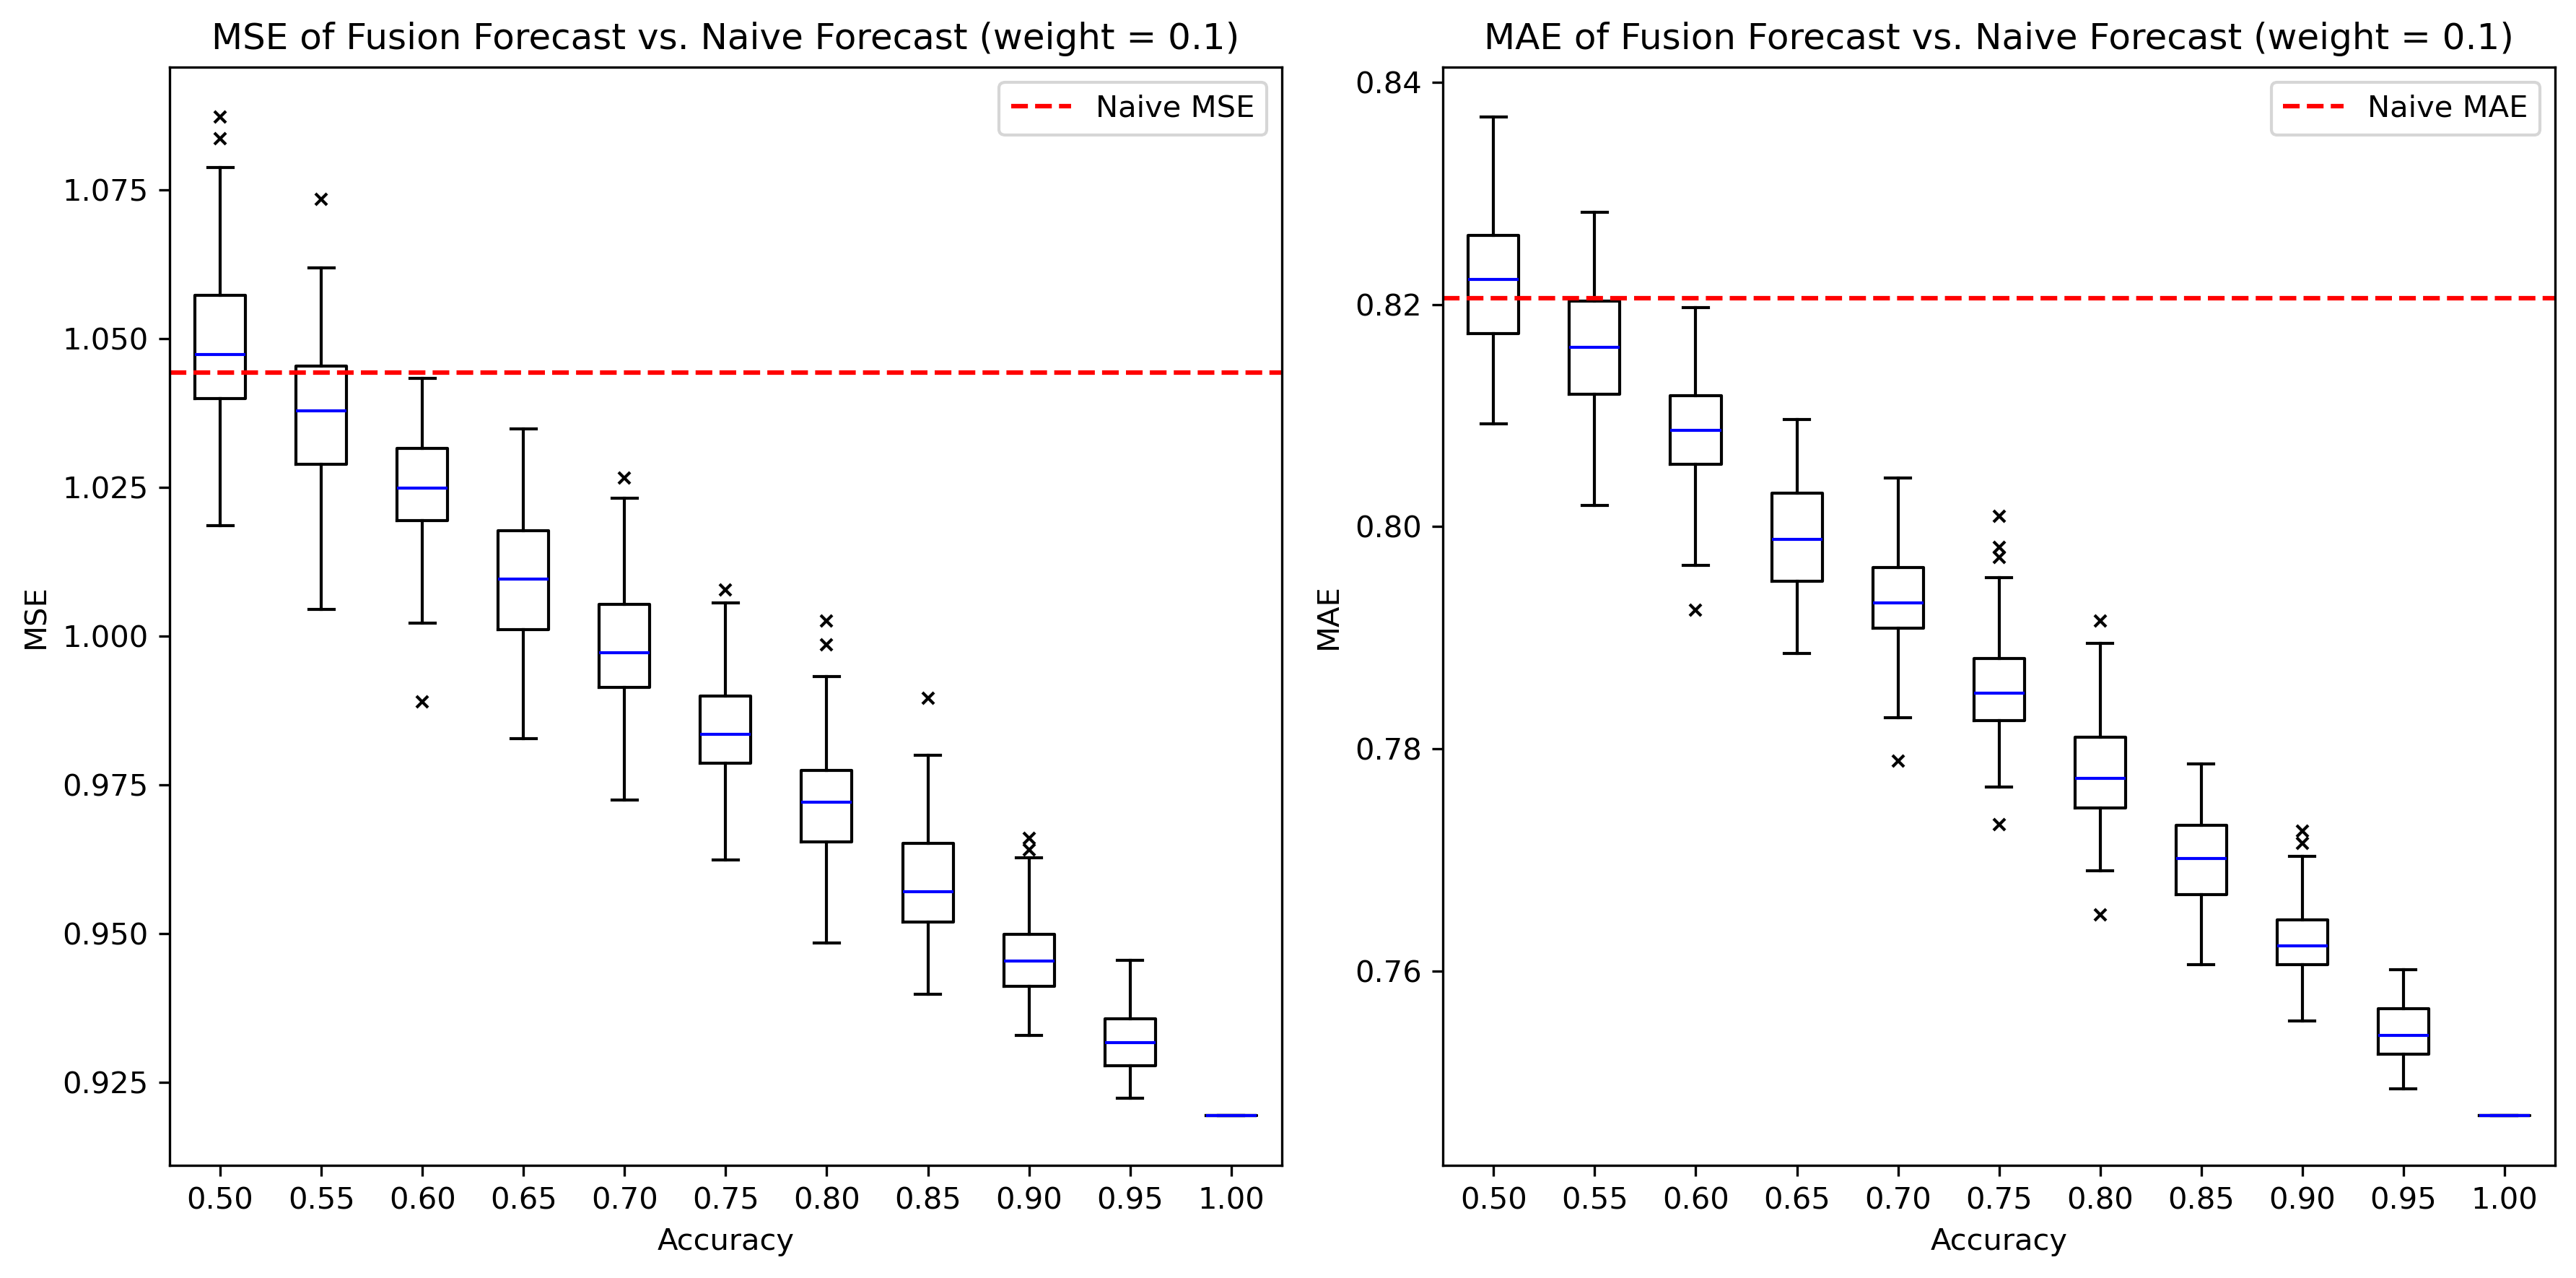

In [21]:
# Prepare data for boxplots
accuracies = sorted(results_df['accuracy'].unique())
all_mae = [results_df[results_df['accuracy'] == acc]['mae_fusion'].values for acc in accuracies]
all_mse = [results_df[results_df['accuracy'] == acc]['mse_fusion'].values for acc in accuracies]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

# MSE boxplot
ax1.boxplot(all_mse, labels=[f"{acc:.2f}" for acc in accuracies], flierprops = flierprops, medianprops = medianprops)
ax1.axhline(y=naive_mse, color='r', linestyle='--', label='Naive MSE')
ax1.set_title('MSE of Fusion Forecast vs. Naive Forecast (weight = 0.1)')
ax1.set_xlabel('Accuracy')
ax1.set_ylabel('MSE')
ax1.legend()

# MAE boxplot
ax2.boxplot(all_mae, labels=[f"{acc:.2f}" for acc in accuracies], flierprops = flierprops, medianprops = medianprops)
ax2.axhline(y=naive_mae, color='r', linestyle='--', label='Naive MAE')
ax2.set_title('MAE of Fusion Forecast vs. Naive Forecast (weight = 0.1)')
ax2.set_xlabel('Accuracy')
ax2.set_ylabel('MAE')
ax2.legend()

plt.tight_layout()
plt.savefig("C:\\Users\\DELL\\Research_projects\\Random_walk_prediction\\figures\\Simulated_random_walk_MAE_MSE_Comparison_0.1.png", dpi=300)
plt.show()

## Weight = 0.5

In [23]:
# Initialize an empty DataFrame outside the loop
results_df = pd.DataFrame()

for accuracy in np.arange(start_accuracy, end_accuracy + accuracy_step, accuracy_step):
    weight = 0.5
    threshold_mse = (2 + weight) / 4
    improvement_mse = (4 * weight * accuracy - weight**2 - 2 * weight) * mean_residual**2
    
    for trial in range(n_trials):
        actual_movements_test = np.sign(np.diff(test_data, prepend=train_data[-1]))
        actual_movements_test = (actual_movements_test == 1).astype(int)
        predicted_movements = np.copy(actual_movements_test)
        mask = np.random.rand(len(test_data)) < accuracy
        incorrect_mask = ~mask
        predicted_movements[incorrect_mask] = 1 - predicted_movements[incorrect_mask]

        y_fusion = np.zeros_like(y_test)  # Assuming y_test is predefined
        for i in range(len(y_test)):
            y_fusion[i] = naive_test[i] + (weight * mean_residual if predicted_movements[i] == 1 else -weight * mean_residual)

        mse_fusion = np.mean((y_test - y_fusion)**2)
        mae_fusion = np.mean(np.abs(y_test - y_fusion))
        

        # Create a temporary DataFrame for this trial and append it
        trial_df = pd.DataFrame({
            'accuracy': [accuracy],
            'trial': [trial],
            'predicted_movements': [predicted_movements.tolist()],  # Convert array to list for storage
            'mse_fusion': [mse_fusion],
            'mae_fusion': [mae_fusion],
            'threshold_mse': [threshold_mse],
            'improvement_mse': [improvement_mse]
        })

        # Append trial_df to results_df
        results_df = pd.concat([results_df, trial_df], ignore_index=True)

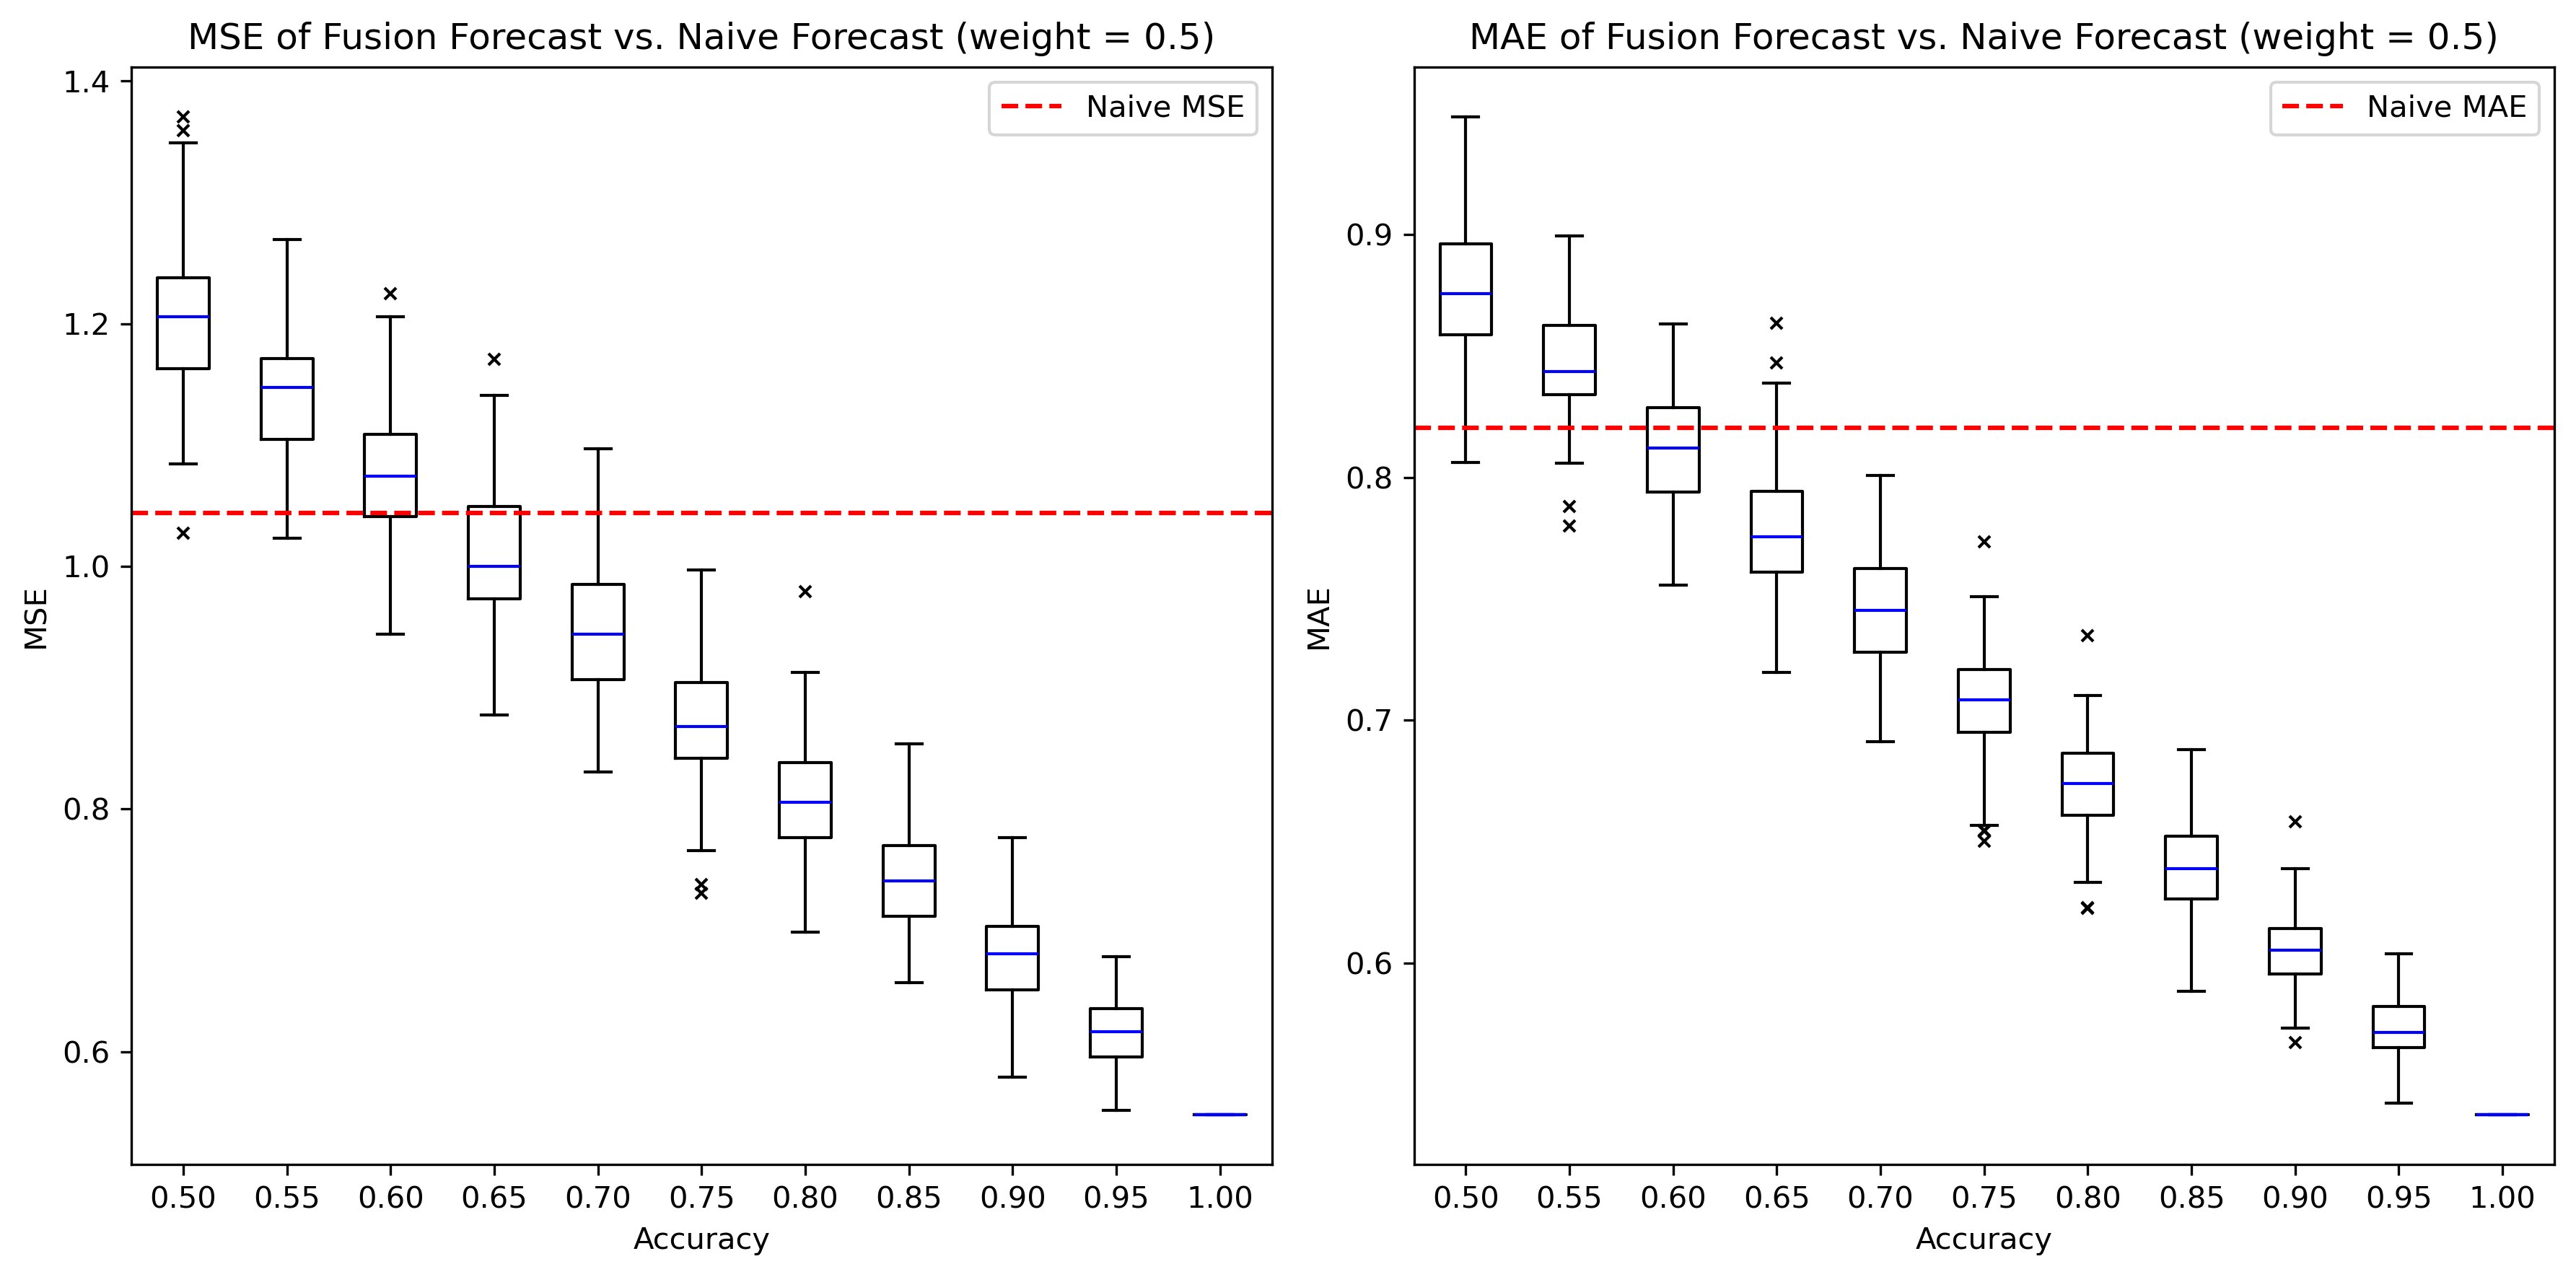

In [24]:
# Prepare data for boxplots
accuracies = sorted(results_df['accuracy'].unique())
all_mae = [results_df[results_df['accuracy'] == acc]['mae_fusion'].values for acc in accuracies]
all_mse = [results_df[results_df['accuracy'] == acc]['mse_fusion'].values for acc in accuracies]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

# MSE boxplot
ax1.boxplot(all_mse, labels=[f"{acc:.2f}" for acc in accuracies], flierprops = flierprops, medianprops = medianprops)
ax1.axhline(y=naive_mse, color='r', linestyle='--', label='Naive MSE')
ax1.set_title('MSE of Fusion Forecast vs. Naive Forecast (weight = 0.5)')
ax1.set_xlabel('Accuracy')
ax1.set_ylabel('MSE')
ax1.legend()

# MAE boxplot
ax2.boxplot(all_mae, labels=[f"{acc:.2f}" for acc in accuracies], flierprops = flierprops, medianprops = medianprops)
ax2.axhline(y=naive_mae, color='r', linestyle='--', label='Naive MAE')
ax2.set_title('MAE of Fusion Forecast vs. Naive Forecast (weight = 0.5)')
ax2.set_xlabel('Accuracy')
ax2.set_ylabel('MAE')
ax2.legend()

plt.tight_layout()
plt.savefig("C:\\Users\\DELL\\Research_projects\\Random_walk_prediction\\figures\\Simulated_random_walk_MAE_MSE_Comparison_0.5.png", dpi=300)
plt.show()


## Weight = 1

In [26]:
# Initialize an empty DataFrame outside the loop
results_df = pd.DataFrame()

for accuracy in np.arange(start_accuracy, end_accuracy + accuracy_step, accuracy_step):
    weight = 1
    threshold_mse = (2 + weight) / 4
    improvement_mse = (4 * weight * accuracy - weight**2 - 2 * weight) * mean_residual**2
    
    for trial in range(n_trials):
        actual_movements_test = np.sign(np.diff(test_data, prepend=train_data[-1]))
        actual_movements_test = (actual_movements_test == 1).astype(int)
        predicted_movements = np.copy(actual_movements_test)
        mask = np.random.rand(len(test_data)) < accuracy
        incorrect_mask = ~mask
        predicted_movements[incorrect_mask] = 1 - predicted_movements[incorrect_mask]

        y_fusion = np.zeros_like(y_test)  # Assuming y_test is predefined
        for i in range(len(y_test)):
            y_fusion[i] = naive_test[i] + (weight * mean_residual if predicted_movements[i] == 1 else -weight * mean_residual)

        mse_fusion = np.mean((y_test - y_fusion)**2)
        mae_fusion = np.mean(np.abs(y_test - y_fusion))
        

        # Create a temporary DataFrame for this trial and append it
        trial_df = pd.DataFrame({
            'accuracy': [accuracy],
            'trial': [trial],
            'predicted_movements': [predicted_movements.tolist()],  # Convert array to list for storage
            'mse_fusion': [mse_fusion],
            'mae_fusion': [mae_fusion],
            'threshold_mse': [threshold_mse],
            'improvement_mse': [improvement_mse]
        })

        # Append trial_df to results_df
        results_df = pd.concat([results_df, trial_df], ignore_index=True)

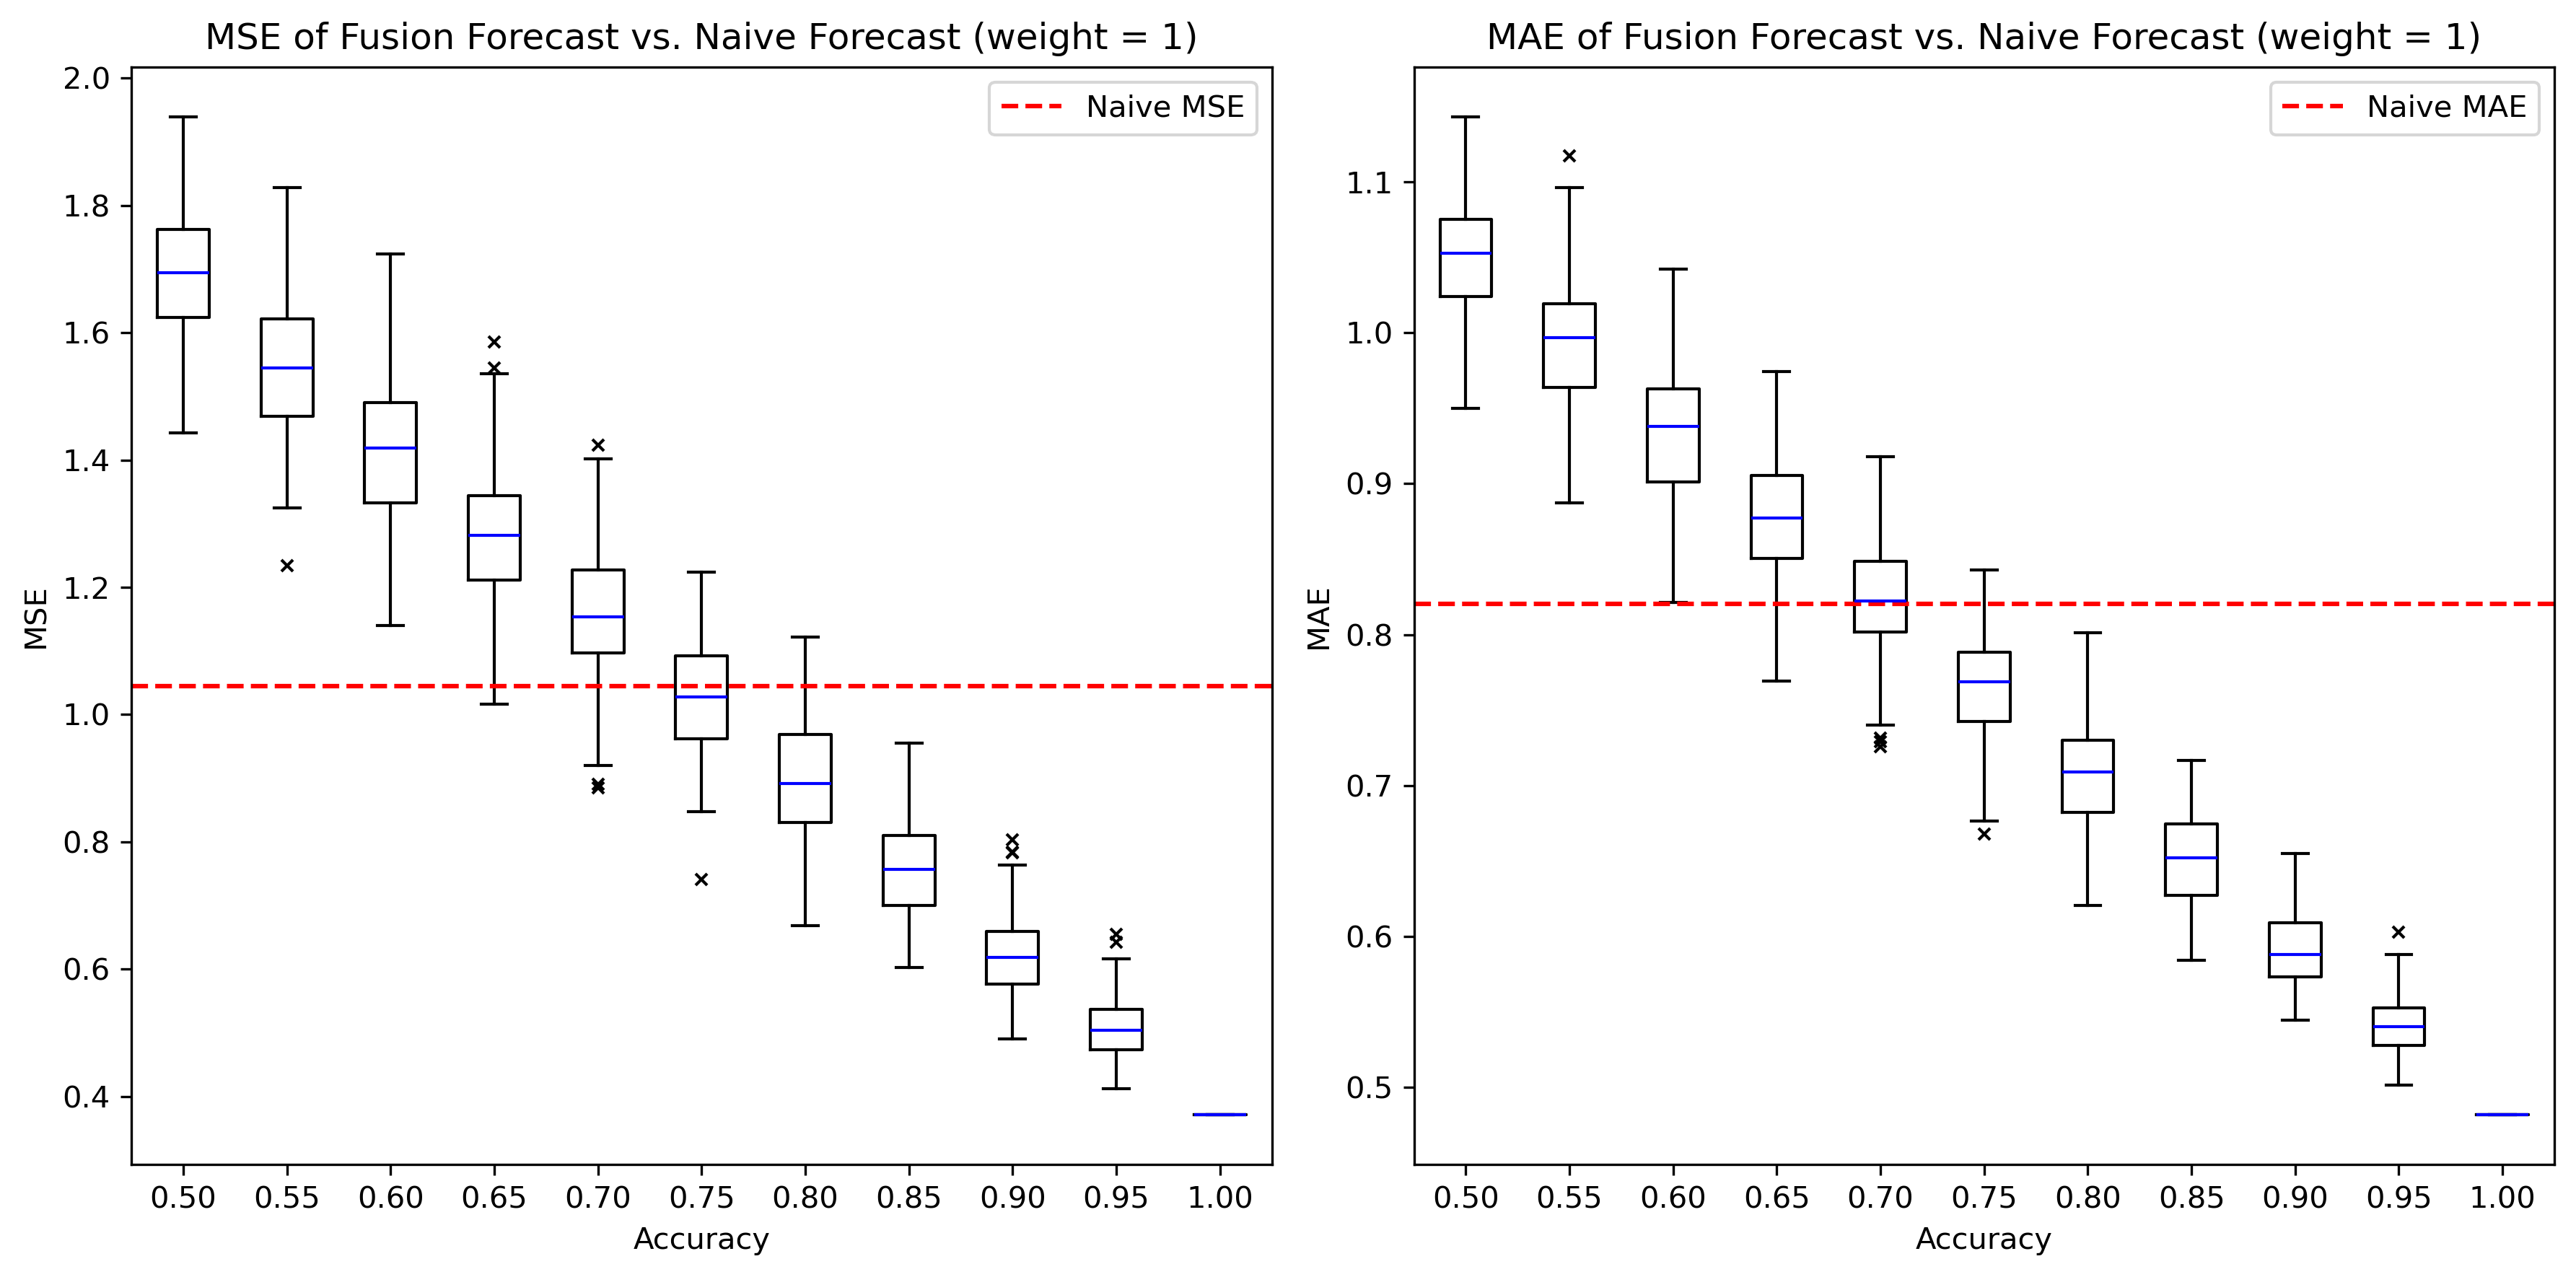

In [27]:
# Prepare data for boxplots
accuracies = sorted(results_df['accuracy'].unique())
all_mae = [results_df[results_df['accuracy'] == acc]['mae_fusion'].values for acc in accuracies]
all_mse = [results_df[results_df['accuracy'] == acc]['mse_fusion'].values for acc in accuracies]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

# MSE boxplot
ax1.boxplot(all_mse, labels=[f"{acc:.2f}" for acc in accuracies], flierprops = flierprops, medianprops = medianprops)
ax1.axhline(y=naive_mse, color='r', linestyle='--', label='Naive MSE')
ax1.set_title('MSE of Fusion Forecast vs. Naive Forecast (weight = 1)')
ax1.set_xlabel('Accuracy')
ax1.set_ylabel('MSE')
ax1.legend()

# MAE boxplot
ax2.boxplot(all_mae, labels=[f"{acc:.2f}" for acc in accuracies], flierprops = flierprops, medianprops = medianprops)
ax2.axhline(y=naive_mae, color='r', linestyle='--', label='Naive MAE')
ax2.set_title('MAE of Fusion Forecast vs. Naive Forecast (weight = 1)')
ax2.set_xlabel('Accuracy')
ax2.set_ylabel('MAE')
ax2.legend()

plt.tight_layout()
plt.savefig("C:\\Users\\DELL\\Research_projects\\Random_walk_prediction\\figures\\Simulated_random_walk_MAE_MSE_Comparison_1.png", dpi=300)
plt.show()